In [1]:
%tensorflow_version 1.x

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import glob
import cv2

import tensorflow as tf
from tensorflow.math import confusion_matrix
import keras
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.models import Model,Sequential
from keras.layers import BatchNormalization,Add
from keras.regularizers import l2,l1
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.applications import *
from keras.layers.core import Activation  
from keras.backend import tensorflow_backend as kb
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from google.colab import drive
drive.mount('/content/drive') 

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## details of thge input image
input_shape = (512,512,3)
weightpath = 'imagenet'
n_classes = 12

## color map instruction
label_value = np.array([[0,0,0],[70,70,70],[153,153,190],[160, 170, 250],[153, 153, 153],[50, 234, 157],[128, 64, 128],[232, 35, 244],[35, 142, 107],[142, 0, 0],[156, 102, 102],[0, 220, 220]])
label_class = np.array(['Unlabeled','Building','Fence','Other','Pole','Road line','Road','Sidewalk','Vegetation','Car','Wall','Traffic sign'])

## path for target and input images
path_y = "/content/drive/My Drive/dataset/carla seg_images/segsumma/"
path_x = "/content/drive/My Drive/dataset/carla seg_images/rgbsumma/"

In [3]:
cnn_models = {'vgg16' : vgg16.VGG16(include_top = False,weights = weightpath,pooling = None,input_shape = input_shape),
              'vgg19' : vgg19.VGG19(include_top = False,weights = weightpath,pooling = None,input_shape = input_shape),
              'resnet' : resnet50.ResNet50(include_top = False,weights = weightpath,pooling = None,input_shape = input_shape),
              'unet' : Unet()}





58892288/58889256 [==============================] - 5s 0us/step






80142336/80134624 [==============================] - 6s 0us/step





/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


In [0]:
## architecture for Unet
## added L2 regularization in some of the layers to prevent overfitting
def Unet():
  
    Input = Input(input_shape, name='input')

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same' (Input)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (u5)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (u8)
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer = l2(0.01)) (c8)

    output = Conv2D(n_classes, (1, 1), activation='softmax',name='output') (c8)

    model = Model(Input,output)
    return model

In [0]:
def build_model(model_name):

  base_model = base_cnn_model(model_name)

  layer_op = base_model.output

  if model_name == 'resnet': skip_1,skip_2 = base_model.get_layer('add_13').output,base_model.get_layer('add_7').output
  elif model_name == 'unet': model = base_model
  else: skip_1,skip_2 = base_model.get_layer('block4_pool').output,base_model.get_layer('block3_pool').output

  layer_encoder = Conv2D(4096,(7,7),padding = 'same',activation = 'relu',kernel_regularizer = l2(0.01),name = 'conv6')(layer_op)
  layer_encoder = Conv2D(4096,(1,1),padding = 'same',activation = 'relu',kernel_regularizer = l2(0.01),name = 'conv7')(layer_encoder)

  layer_decoder = Conv2DTranspose(skip_1.get_shape().as_list()[-1],(4,4),strides = (2,2),padding = 'same',kernel_regularizer = l2(0.01),name = 'deconv1')(layer_encoder)
  layer_decoder = Add(name = 'skip1')([layer_decoder,skip_1])
  layer_decoder = Conv2DTranspose(skip_2.get_shape().as_list()[-1],(4,4),strides = (2,2),padding = 'same',kernel_regularizer = l2(0.01),name = 'deconv2')(layer_decoder)
  layer_decoder = Add(name = 'skip2')([layer_decoder,skip_2])
  layer_decoder = Conv2DTranspose(n_classes,(16,16),strides = (8,8),padding = 'same',kernel_regularizer = l2(0.01),name = 'deconv3')(layer_decoder)
  
  output = Activation('softmax')(layer_decoder)

  model = Model(base_model.input,output)
  model.summary()

  return model

In [0]:
## customized loss function particularly for class imbalance
def weighted_loss(y_true,y_pred):
  ## alpha takes class weights,1 if no class imbalance
  alpha,beta = 1. , 2.

  eps = kb.epsilon()

  ## clipping the predicted class probability values with eps inorder to prevent exploding numbers, eps < y_pred < 1-eps 
  y_pred = kb.clip(y_pred,eps,1.-eps)

  ## normal categorical cross-entropy --> Yt*log(Yp)
  ce = -(y_true * kb.log(y_pred))
    
  ## adding the weightage factors --> alpha and (1-Yp)^beta
  weighted_ce = alpha * kb.pow(1.-y_pred,beta) * ce 
    
  ## since the output is an image with loss for each pixels, adding the loss for each pixel per image
  for i in range(3): 
    weighted_ce = kb.sum(weighted_ce,axis = -1)
    
  ## finally taking avg. over the mini-batch
  batch_weighted_ce = (kb.mean(weighted_ce,axis = 0)/10)

  return batch_weighted_ce

In [0]:
def train_model(train_x,train_y,val_x,val_y,model,lr = 0.001,b1 = 0.9,b2 = 0.999,batch_size = 32,epochs = 30,x = 6):

  for i in range(1,x+1): model.layers[i].trainable = False

  callbacks = [ EarlyStopping(monitor = 'val_loss',patience = 9,min_delta = 0.01),ModelCheckpoint('seg_model.h5',monitor = 'val_loss',save_best_only = True),ReduceLROnPlateau(monitor = 'val_loss',patience = 9) ]

  optimizer = Adam(lr = lr,beta_1 = b1,beta_2 = b2)

  model.compile(optimizer = optimizer,loss = weighted_loss,metrics = [mIoU])
  model.fit(train_x,train_y,batch_size = batch_size,callbacks = callbacks,epochs = epochs,validation_data = (val_x,val_y))

  return model

In [0]:
## mean intersection over union, a metric 
def mIoU(Y_true, Y_pred):

  # ytrue, ypred is a flatten vector
  Y_pred = kb.flatten(kb.argmax(Y_pred,axis = -1))
  Y_true = kb.flatten(kb.argmax(Y_true,axis = -1))
  # getting confusion matrix 
  con_mat = confusion_matrix(Y_true, Y_pred, num_classes = n_classes)
  # convert to float value
  con_mat = kb.cast(con_mat, kb.floatx())
  # compute mean iou
  intersection = kb.sum(con_mat * kb.eye(n_classes), axis=-1)
  ground_truth_set = kb.sum(con_mat,axis = 1)
  predicted_set = kb.sum(con_mat,axis = 0)
  union = ground_truth_set + predicted_set - intersection
  IoU = intersection/union
  
  return kb.mean(IoU)

In [0]:
def pixel_accuracy(Y_true,Y_pred):
  
  # flattening the values and getting the class index
  Y_pred = kb.flatten(kb.argmax(Y_pred,axis = -1))
  Y_true = kb.flatten(kb.argmax(Y_true,axis = -1))
  # build a confusion matrix 
  con_mat = confusion_matrix(Y_true,Y_pred,num_classes = n_classes)
  # get them as float values
  con_mat = kb.cast(con_mat, kb.floatx())
  # extract the number of correct guesses from the diagonal
  correct = kb.sum(con_mat * kb.eye(n_classes), axis=-1)
  # extract the number of total values per class from ground truth
  total = kb.sum(con_mat, axis=-1)
  # per class accuracy
  class_acc = (correct/total)
  # calculate the total accuracy
  return (kb.sum(correct) / kb.sum(total))


In [0]:
## converting target image data to one-hot before passing to the model and vice-versa
def convert_image(data1,data2,data3,data4):

  for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
      for k in range(data1.shape[2]):
        for c in range(n_classes):
          if max(abs(data1[i,j,k]-data2[c])) == 0: 
            data4[i,j,k] = data3[c]
            break
  return data4      


In [11]:
## reading the data from image
data_y = np.array([cv2.imread(filename,cv2.IMREAD_COLOR) for filename in glob.glob(path_y+'*.png')])
data_x = np.array([cv2.imread(filename,cv2.IMREAD_COLOR) for filename in glob.glob(path_x+'*.png')])
 
print(data_x.shape)
print(data_y.shape)

(4, 512, 512, 3)
(4, 512, 512, 3)


In [0]:
data_y_1hot = np.zeros([data_y.shape[0],data_y.shape[1],data_y.shape[2],n_classes])
label_1hot = tf.one_hot([0,1,2,3,4,5,6,7,8,9,10,11],depth = n_classes)

label_1hot = label_1hot.eval(session=tf.Session())

data_y_1hot = convert_image(data_y,label_value,label_1hot,data_y_1hot)

In [0]:
## converting data into tensors
#tensor_y_1hot = tf.constant(data_y_1hot)
#tensor_x = tf.constant(data_x)
## splitting into train and test data
x_train,y_train = np.take(data_x,[0,1,2],axis = 0),np.take(data_y_1hot,[0,1,2],axis = 0)

x_val,y_val = np.take(data_x,[3,0],axis = 0),np.take(data_y_1hot,[3,0],axis = 0)

In [14]:
Model = build_model('vgg16')


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [26]:
trained_model = train_model(x_train,y_train,x_val,y_val,Model,batch_size = 1,epochs = 2)

Train on 3 samples, validate on 2 samples
Epoch 1/2
3/3 [==============================] - 41s 14s/step - loss: 390912.5417 - mIoU: 0.0207 - val_loss: 341256.8281 - val_mIoU: 0.0368
Epoch 2/2
3/3 [==============================] - 31s 10s/step - loss: 375612.1146 - mIoU: 0.0260 - val_loss: 384446.4688 - val_mIoU: 0.0231


In [0]:
pred = trained_model.predict(x_val,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


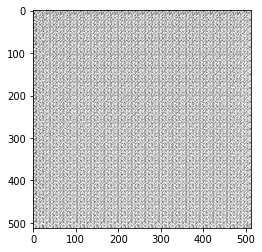

[1 3 4]
